# Analyzing US Census Data for HigherME
**Nava Roohi ,Cole Bailey, Filipp Krasovsky**

In [1]:
import pandas as pd 

In [2]:
df = pd.read_csv("new_df_3_age_filtered.csv")
df.head()

,YEAR,MULTYEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,STATEFIP,STRATA,GQ,...,EDUCD,DEGFIELD,DEGFIELDD,DEGFIELD2,DEGFIELD2D,EMPSTAT,EMPSTATD,OCC,IND,INCWAGE
0,2020,2017,202003,2817124,2017000546615,38.11,2020028171243,24,50224,1,...,114,29,2901,0,0,1,10,7700,670,68637
1,2020,2016,202003,2020495,2016000885630,24.72,2020020204953,17,190017,1,...,114,61,6109,0,0,1,10,3255,7970,86293
2,2020,2020,202003,3734784,2020000349780,37.08,2020037347843,32,40932,1,...,63,0,0,0,0,1,10,4760,5170,28000
3,2020,2017,202003,1404902,2017000403159,33.99,2020014049023,12,950912,1,...,81,0,0,0,0,1,10,4000,8660,86588
4,2020,2019,202003,1646896,2019001221265,11.33,2020016468963,12,10212,1,...,101,36,3600,52,5200,1,10,8740,5580,19136


In [3]:
#sanity check to make sure our age is above 18
df['AGE'].min()

18

## Data Cleaning

#### Step 1. State Extraction from FIP Numbers

In [4]:
fips = {
    1:"Alabama",2:"Alaska",4:"Arizona",5:"Arkansas",6:"California",8:"Colorado",9:"Connecticut"
    ,10:"Delaware",11:"District of Columbia",12:"Florida",13:"Georgia",15:"Hawaii",16:"Idaho"
    ,17:"Illinois",18:"Indiana",19:"Iowa",20:"Kansas",21:"Kentucky",22:"Louisiana",23:"Maine"
    ,24:"Maryland",25:"Massachusetts",26:"Michigan",27:"Minnesota",28:"Mississippi",29:"Missouri"
    ,30:"Montana",31:"Nebraska",32:"Nevada",33:"New Hampshire",34:"New Jersey",35:"New Mexico"
    ,36:"New York",37:"North Carolina",38:"North Dakota",39:"Ohio",40:"Oklahoma",41:"Oregon"
    ,42:"Pennsylvania",44:"Rhode Island",45:"South Carolina",46:"South Dakota",47:"Tennessee"
    ,48:"Texas",49:"Utah",50:"Vermont",51:"Virginia",53:"Washington",54:"West Virginia"
    ,55:"Wisconsin",56:"Wyoming",61:"Maine-New Hampshire-Vermont",62:"Massachusetts-Rhode Island"
    ,63:"Minnesota-Iowa-Missouri-Kansas-Nebraska-S.Dakota-N.Dakota",64:"Maryland-Delaware"
    ,65:"Montana-Idaho-Wyoming",66:"Utah-Nevada",67:"Arizona-New Mexico",68:"Alaska-Hawaii"
    ,72:"Puerto Rico",97:"Military/Mil. Reservation",99:"State not identified"
}

In [5]:
#map to a new variable called "State"
df['State'] = df['STATEFIP'].apply(lambda x:fips[x])
df.head()

,YEAR,MULTYEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,STATEFIP,STRATA,GQ,...,DEGFIELD,DEGFIELDD,DEGFIELD2,DEGFIELD2D,EMPSTAT,EMPSTATD,OCC,IND,INCWAGE,State
0,2020,2017,202003,2817124,2017000546615,38.11,2020028171243,24,50224,1,...,29,2901,0,0,1,10,7700,670,68637,Maryland
1,2020,2016,202003,2020495,2016000885630,24.72,2020020204953,17,190017,1,...,61,6109,0,0,1,10,3255,7970,86293,Illinois
2,2020,2020,202003,3734784,2020000349780,37.08,2020037347843,32,40932,1,...,0,0,0,0,1,10,4760,5170,28000,Nevada
3,2020,2017,202003,1404902,2017000403159,33.99,2020014049023,12,950912,1,...,0,0,0,0,1,10,4000,8660,86588,Florida
4,2020,2019,202003,1646896,2019001221265,11.33,2020016468963,12,10212,1,...,36,3600,52,5200,1,10,8740,5580,19136,Florida


### Step 2. Breakdown by Race, Initial EDA 

In [6]:
race_map ={
    1: "White"
    ,2: "Black/African American"
    ,3: "American Indian or Alaska Native"
    ,4: "Chinese"
    ,5: "Japanese"
    ,6: "Other Asian or Pacific Islander"
    ,7: "Other race, nec"
    ,8: "Two major races"
    ,9: "Three or more major races"
}
df['RACE'].apply(lambda x: race_map[x]).value_counts()

White                               145619
Black/African American               18391
Other Asian or Pacific Islander       7399
Other race, nec                       7056
Two major races                       5609
Chinese                               2766
American Indian or Alaska Native      2070
Three or more major races              547
Japanese                               543
Name: RACE, dtype: int64

Based on the definition, however, we are primarily interested in exploring career differences between non-white/asian individuals and their counterparts based on documentation that can be accessed <a href="https://github.com/kayfilipp/HigherME/blob/main/README.md">here</a>. To this end, we can re-map the race for each row to exclude indices 1, 4, and 5. We do not exclude pacific islanders as of now, but are open to doing so if requirements change.

In [7]:
non_target = [1,4,5]
def under_rep_id(race,hispan):
    #if target is not 'Non-Hispanic'
    if hispan != 0:
        return 1
    #or nonwhite/asian...
    if race not in non_target:
        return 1
    return 0

df['under_represented'] = df.apply(lambda x: under_rep_id(x.RACE,x.HISPAN),axis=1)
df[['RACE','under_represented']].sample(10)

,RACE,under_represented
149103,1,0
28933,1,0
38885,1,0
51930,8,1
40307,1,0
37286,1,0
96503,1,0
62460,1,0
178691,1,0
132222,1,0


<AxesSubplot:title={'center':'Under represented presence in dataset'}>

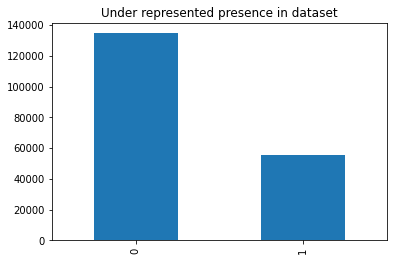

In [8]:
df['under_represented'].value_counts().plot(kind='bar',title='Under represented presence in dataset')

#### Since we're not doing low level analysis that explores the differences between Black and Hispanic applicants, we can drop the nuance on hispanic data for now.

In [9]:
df = df.drop(['HISPAN','HISPAND'],axis=1)

### Step 3. Breakdown by Birthplace, EDA

#### Furthermore, we can divide the birthplace feature (BPL) into a more low-resolution field - foreign born and domestic born individuals (ie those who are born in the continental US):

In [10]:
def is_domestic(bpl):
    #if birthplace code is for the US...
    if bpl < 100:
        return 1
    return 0

df['domestic_born'] = df['BPL'].map(is_domestic)
df[['BPL','domestic_born']].head()

,BPL,domestic_born
0,24,1
1,17,1
2,210,0
3,6,1
4,22,1


Putting all this together, we can conclude that individuals that are born abroad and move to the US tend to be underepresented, while, as intiuition dictates, individuals born in the US tend to not be underrepresented. 

<AxesSubplot:title={'center':'Distribution of Underrepresented persons by birthplace'}, xlabel='domestic_born'>

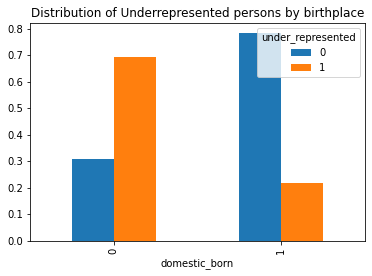

In [11]:
pd.crosstab(
    df['domestic_born'],
    df['under_represented'],
    normalize='index'
).plot.bar(
    title='Distribution of Underrepresented persons by birthplace'
)

### Step 4. Educational Attainment, EDA

**Context:** The ``EDUC`` field contains values from 0-11 representing levels of educational attainment in increasing order - that is, a 0 is lower than a 1, etc. The `EDUCD` field extrapolates on the low-level details in a similar fashion. Our primary motivation is to simplify these values broadly into the following categories:

<ul>
    <li>None/Below Secondary (High School)</li>
    <li>Secondary (High School)</li>
    <li>Associate's</li>
    <li>Bachelor's</li>
    <li>Master's</li>
    <li>PhD/Other</li>
</ul>

In [12]:
df['EDUC'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11], dtype=int64)

In [13]:
df['EDUCD'].sort_values().unique()

array([  2,  11,  12,  14,  15,  16,  17,  22,  23,  25,  26,  30,  40,
        50,  61,  63,  64,  65,  71,  81, 101, 114, 115, 116], dtype=int64)

In [14]:
def highest_edu(educd):
    if educd in [81,82,83]:
        return 'Associate'
    if educd == 101:
        return 'Bachelor'
    if educd in [114,115]:
        return 'Master'
    if educd in [116]:
        return 'PhD'
    if educd < 62 or educd==999:
        return 'None/Below HS'
    if educd < 114:
        return 'High School'
    
df['EDU_verbose'] = df['EDUCD'].map(highest_edu)
df[['EDU_verbose','EDUCD']].tail()

,EDU_verbose,EDUCD
189995,High School,64
189996,Associate,81
189997,Master,114
189998,High School,63
189999,High School,63


<AxesSubplot:title={'center':'Distribution of Underrepresented persons by degree attainment'}, xlabel='under_represented'>

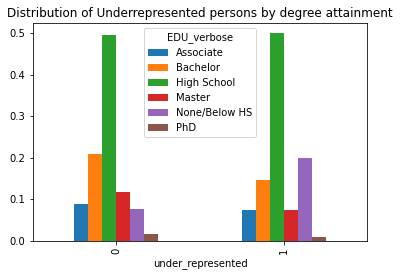

In [15]:
pd.crosstab(
    df['under_represented'],
    df['EDU_verbose'],
    normalize='index'
).plot.bar(
    title='Distribution of Underrepresented persons by degree attainment'
)

major takeaways here include the fact that under-represented persons tend to drop out of high school at a far greater rate while earning fewer high school diplomas, master's degrees, associate's degrees, and bachelor's degrees.

### Employment, EDA

we first observe the difference in employment status across represented and underepresented groups and find that most of the populartion is employed in both groups, but under-represented communities tend to be more unemployed.

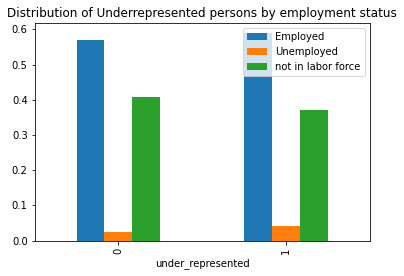

In [16]:
import matplotlib.pyplot as plt
pd.crosstab(
    df['under_represented'],
    df['EMPSTAT'],
    normalize='index'
).plot.bar(
    title='Distribution of Underrepresented persons by employment status'
)
plt.legend(['Employed','Unemployed','not in labor force'])

#### Analyzing STEM Education in Particular
In order to identify if a degree belong to a stem field, we have two tiers of analysis - one at the `DEGFIELD` level, which shows us a high-level description of the degree in question. If we do not confirm at this level that a field of study is STEM, we move into the `DEGFIELDD` field, which offers more specific information on the degree.

**for this section, we have developed a separate library containing logic that separates both DEGFIELD and DEGFIELDD codes into stem designation.**

In [17]:
import degree_codes as dc

In [19]:
df['is_STEM'] = df.apply(lambda x: dc.is_stem_degree(x.DEGFIELD,x.DEGFIELDD),axis=1)

In [20]:
df[['DEGFIELD','DEGFIELDD','is_STEM']].head()

,DEGFIELD,DEGFIELDD,is_STEM
0,29,2901,0
1,61,6109,1
2,0,0,0
3,0,0,0
4,36,3600,1


#### STEM Degree Attainment by Target Variable
A cursory analysis suggests that underrepresented individuals in STEM tend to have a significantly lower presence than 

<AxesSubplot:title={'center':'Distribution of Underrepresented persons by STEM attainment'}, xlabel='is_STEM'>

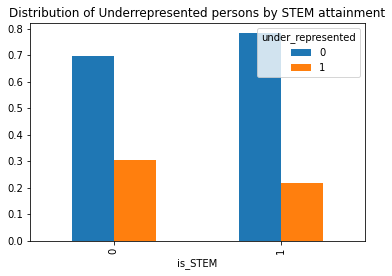

In [25]:
pd.crosstab(
    df['is_STEM'],
    df['under_represented'],
    normalize='index'
).plot.bar(
    title='Distribution of Underrepresented persons by STEM attainment'
)